<a class="anchor" id="toc-go-back"></a>
# Assignment 3: Day-ahead scheduling from the perspective of the system operator

### Table of Contents
* [1. Loading the data](#data-loading)
* [2. Setup optimization problem](#optimziation-problem-setup)
* [3. Running the optimization model ](#run-optimization)
* [4. Can we solve the problem using machine learning?](#machine-learning)
* [5. Extra ](#extra)

First of all, we refer to the hand-in for an in-depth description of the problem formulation and the optimization problem. This notebooks focuses on implementing the model using ```Gurobipy``` and an additional part using machine learning. 

We start by loading the relevant modules.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import gurobipy as grb

In [2]:
DATA_DIR = Path('../data')

<a class="anchor" id="data-loading"></a>
## 1. Loading the data

We initially load the data files given to us with the assignment description. This will later on be used as input to the optimization model from which we can then find the optimal values of the decision variables.

In [3]:
# Load data files from csv-files
pmax    = pd.read_csv(DATA_DIR / 'pgmax.csv')
pmin    = pd.read_csv(DATA_DIR / 'pgmin.csv')
ru      = pd.read_csv(DATA_DIR / 'ramp.csv')
UT      = pd.read_csv(DATA_DIR / 'lu.csv')
DT      = pd.read_csv(DATA_DIR / 'ld.csv')    
demand  = pd.read_csv(DATA_DIR / 'Demand.csv', sep=';')   
c_op    = pd.read_csv(DATA_DIR / 'cost_op.csv') 
c_st    = pd.read_csv(DATA_DIR / 'cost_st.csv') 
PTDF    = pd.read_csv(DATA_DIR / 'PTDF.csv', sep=';') 
busgen  = pd.read_csv(DATA_DIR / 'busgen.csv', sep=';')
busload = pd.read_csv(DATA_DIR / 'busload.csv', sep=';')
fmax    = pd.read_csv(DATA_DIR / 'fmax.csv')

# 
Hg      = pd.DataFrame(np.dot(PTDF, busgen), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Gen {i+1}' for i in range(busgen.shape[1])])
Hl      = pd.DataFrame(np.dot(PTDF, busload), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Load {i+1}' for i in range(busload.shape[1])])

# Load load profile samples
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)

With the data set loaded, we can now define the basics underlying the optimization problem - thus, we start by defining the numerical values of the parameters.

In [4]:
N_g     = busgen.shape[1]   # the number of generator units
N_t     = demand.shape[0]   # next 24 hours
N_load  = busload.shape[1]  # the number of load buses
N_lines = PTDF.shape[0]     # the number of transmission lines

<a class="anchor" id="optimization-problem-setup"></a>
## 2. Setup optimization problem

Differences between the hand-in and the proposed formula from class:
1. start-up cost is deterministic and should not be optimized for (i.e. input parameter and not decision variable)
2. demand is additionally indexed by time for the flow constraint
3. the start-up constraint is added by specifying an on/off variable for each unit at each time, $b$.

Now, we are ready to define the decision variables of the optimization problem. These relate to the start-up status and production of generator units at each time step of the day. We additionally include a variable for denoting the on/off status. As we are given a data file for start-up costs for each generation unit, we approach the problem with the start-up cost being time-independent and consider it as an input rather than a decision variable.

Next, we add the constraints to the optimization model. Overall these concern:
1) Power balance equation, i.e. the total production must equal the total demand. Here, we add the concept of slack variable for feasibility - i.e. making sure that the problem can be solved even if in some cases the demand is not met.
2) Generation limits, ensuring that the generator units do not produce more than their maximum capacity.
3) Ramp-up and ramp-down constraints, ensuring...
4) Line technical limits, ensuring that the flow between busses does not exceed the maximum capacity of the line.
5) Minimum on/off times.
6) Start-up constraints for turning on a generator unit (i.e. the unit must be off in the previous time step).

Lastly, we define the objective function for the optimization problem. This is defined as minimizing the total cost - i.e. production cost and start-up cost. In this case, we assume deterministic start-up costs for each generator unit - in other words, we assume that they are time-independent.

These three steps have been implemented in a wrapper object related to the 118-bus system, namely the ```BUS118```-class defined below.

In [56]:
class BUS118:
    
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(N_g, N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(N_g, N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(N_g, N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasability of the power balance equations
        self.eps    = self.model.addVars(N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)

        for t in tqdm(range(N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(sum(self.p[g_n, t] for g_n in range(self.N_g)) == sum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g)) 
                line_expr2  = grb.quicksum(self.Hl.iloc[l, n] * self.demand_profile.iloc[t, n] for n in range(self.N_load))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]
                                
                # LHS
                self.model.addConstr(line_expr <= self.fmax.iloc[l].item(), name=f'pos_line_flow_limit[{l},{t}]')
                # RHS
                self.model.addConstr(-self.fmax.iloc[l].item() <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')
                
        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = sum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * sum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

<a class="anchor" id="run-optimization"></a>
## 3. Running the optimization model

For being able to run experiments, the optimization model has been collected in an object - namely, the ```BUS118```-class. 

In [58]:
# SOLVED # QUESTION: do we need the start-up cost constraint (i.e. s_gt) when having it as an input variable?
# SOLVED # QUESTION: what is the M variable in the modified cost function? Is it a sort of penalization parameter?
# IRRELEVANT # QUESTION: what is the decision variable q denoting? for the modified cost function?
# QUESTION: load profile - what do they mean by samples of load?
# QUESTION: why does sample code only use <= fmax when slides show also >= - fmax ?

In [59]:
system = BUS118(
    N_g=N_g, N_t=N_t, N_load=N_load, N_lines=N_lines,
    demand=demand,
    pmin=pmin, pmax=pmax,
    Hg=Hg, Hl=Hl, fmax=fmax,
    UT=UT, DT=DT, ru=ru,
    c_op=c_op, c_st=c_st,
)

In [60]:
# Select a load profile
load_profile = samples.iloc[0, :].values[np.newaxis, :]

# Optimize system with specified load profile
opt = system.optimize(load_profile, M=1000)

Adding constraints...:   0%|          | 0/24 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [02:29<00:00,  6.23s/it]


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11375H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2442902 - for non-commercial use only - registered to ak___@dtu.dk
Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x3a174355
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 4163 rows and 30 columns
Presolve time: 1.02s
Presolved: 18843 rows, 3906 columns, 310325 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.573689e+05, 520 iterations, 0.12 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

In [62]:
# Prepare data format for results
on_off      = -1 * np.ones((system.N_g, system.N_t))
start_up    = -1 * np.ones((system.N_g, system.N_t))
power       = -1 * np.ones((system.N_g, system.N_t))
cost        = -1 * np.ones((system.N_g, system.N_t))
delta       = -1 * np.ones((system.N_t, 1))
eps         = -1 * np.ones((system.N_t, 1))

# Extract results
for t in range(24):
    for g in range(N_g):
        # Generator dependent results
        on_off[g, t]    = system.b[g, t].x
        start_up[g, t]  = system.u[g, t].x
        power[g, t]     = system.p[g, t].x
        cost[g, t]      = system.c_op.iloc[g, 0] * system.p[g, t].x + system.c_st.iloc[g, 0] * system.u[g, t].x

    # Slack variables
    eps[t, 0]   = system.eps[t, 0].x
    delta[t, 0] = system.delta[t, 0].x

# For some reason, some zeros get a minus in front - taking the absolute value does not change the value, only the visual outline of the matrix
on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
power       = pd.DataFrame(power,           columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
cost        = pd.DataFrame(cost,            columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])

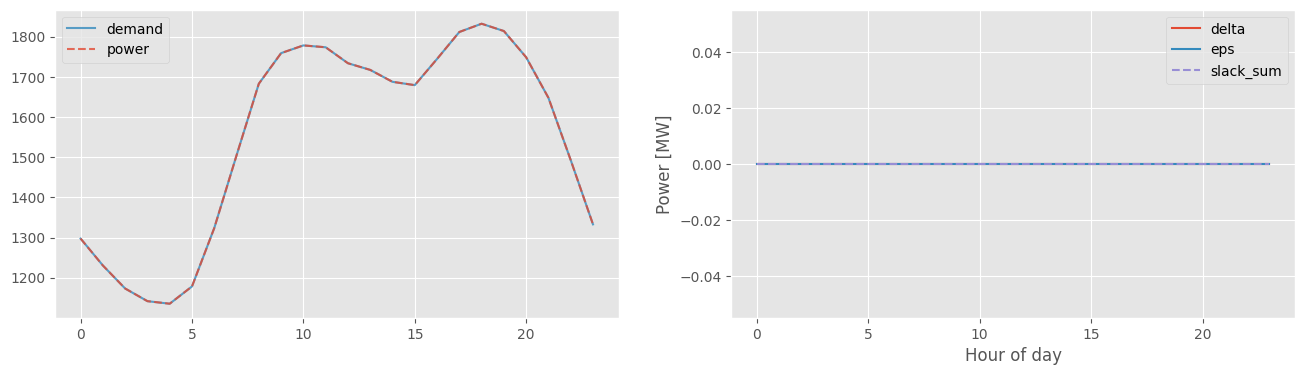

In [63]:
# Check if power balance equation is satisfied 
power_balance = pd.DataFrame(
    [system.demand_profile.sum(axis=1).values, power.sum(axis=0).values, eps.flatten(), delta.flatten(), (eps + delta).flatten()], 
    index=['demand', 'power', 'eps', 'delta', 'slack_sum'
]).T
assert np.allclose(power_balance['demand'], power_balance[['power', 'eps', 'delta']].sum(axis=1)), 'Power balance equation not satisfied !'

fig, axs = plt.subplots(1, 2, figsize=(16, 4)) 
power_balance.plot(y=['demand'], color='C1', ls='-', alpha=0.8, ax=axs[0])
power_balance.plot(y=['power'], color='C0', ls='--', alpha=0.8, ax=axs[0])
power_balance.plot(y=['delta', 'eps'],      ax=axs[1])
power_balance.plot(y='slack_sum', ls='--',  ax=axs[1])
plt.xlabel('Hour of day')
plt.ylabel('Power [MW]')
plt.show()

Total cost of the system:  357556.62408468715


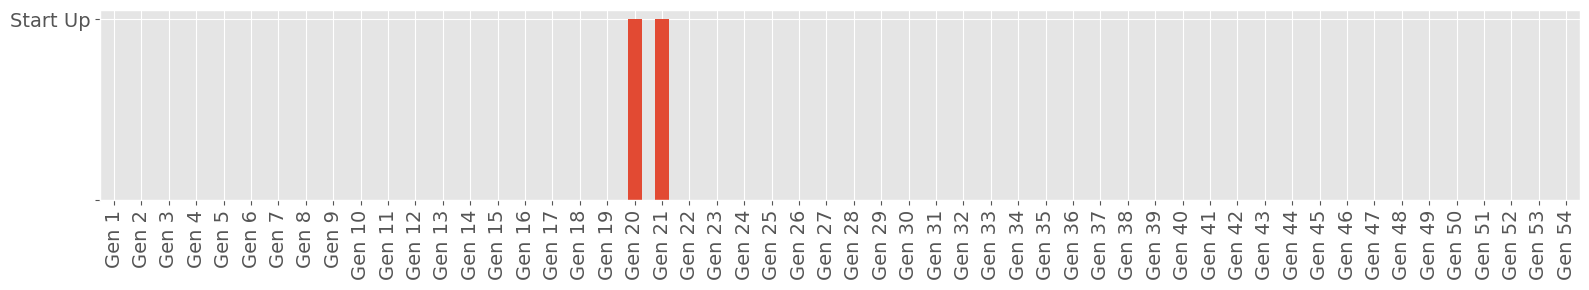

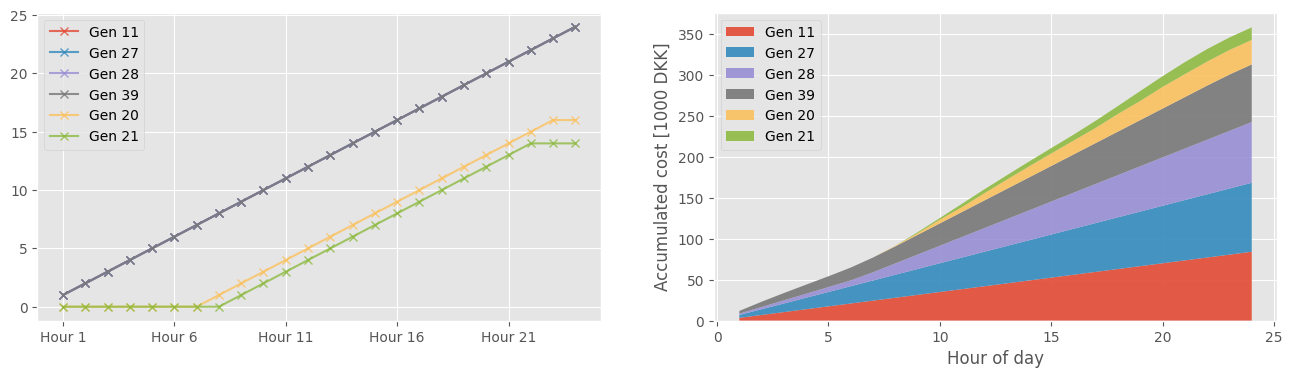

,Hour 6,Hour 7,Hour 8,Hour 9,Hour 10,Hour 11,Hour 12,Hour 13,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
Gen 20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gen 21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
print("Total cost of the system: ", sum(cost.values.flatten()))

# Shwo start up status
start_up.sum(axis=1).plot(kind='bar', figsize=(16, 3))
plt.yticks([0, 1], ['', 'Start Up'], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

### Create production cost curves
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
generators_turned_on = on_off.sum(axis=1) != 0

# Visalize when the generators are turned on
on_off[generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False).T.plot(ax=axs[0], ls='-', marker='x', alpha=0.8)

# Visualize the cost of the system for each turned on generator
axs[1].stackplot(
    np.arange(1, 25), 
    cost[generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False) / 1000, 
    labels=cost[generators_turned_on].sort_values(by='Hour 24', ascending=False).index,
    alpha=0.9,
)
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Hour of day')
axs[1].set_ylabel('Accumulated cost [1000 DKK]')
plt.show()

start_up[start_up.sum(axis=1) != 0].iloc[:, 5:]

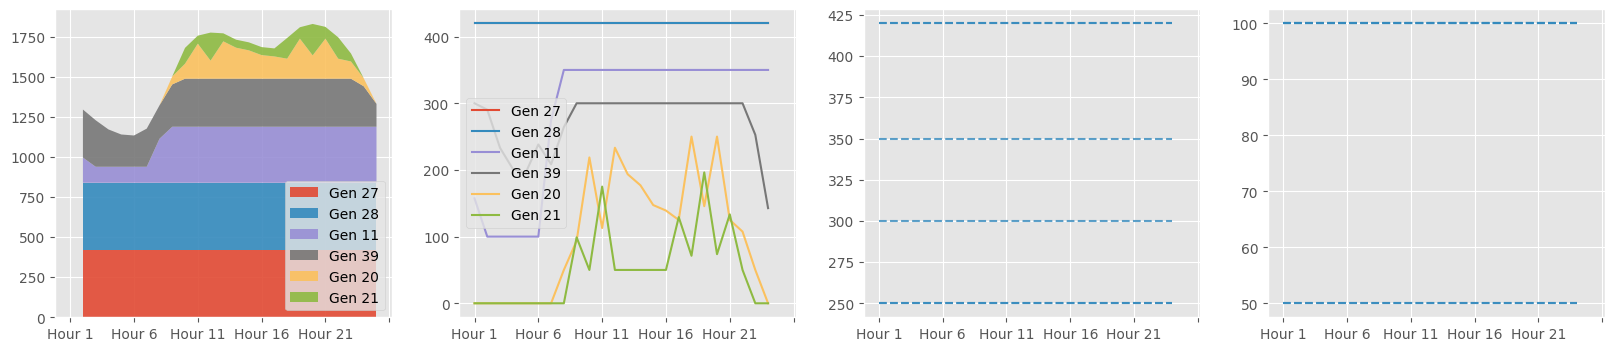

In [124]:
system.pmax['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmax = system.pmax.set_index('index')

system.pmin['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmin = system.pmin.set_index('index')

power['total_production'] = power[generators_turned_on].cumsum(axis=1)['Hour 24']


fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=False, sharex=True)
axs[0].stackplot(
    np.arange(1, 25), 
    power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production'), 
    labels=power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').index,
    alpha=0.9,
)
axs[0].legend(loc='lower right')
power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').T.plot(ax=axs[1])

axs[2].hlines(y=system.pmax[generators_turned_on].T.values, xmin=0, xmax=23, color='C1', ls='--', alpha=0.8)
axs[3].hlines(y=system.pmin[generators_turned_on].T.values, xmin=0, xmax=23, color='C1', ls='--', alpha=0.8)

In [65]:
constraints = pd.DataFrame([{
    'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
    'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
    'constraint_slack': c.Slack, 
    'rhs': c.getAttr('rhs')
} for c in system.model.getConstrs()])

In [68]:
grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

line_flow_limits = grouped_constraints['pos_line_flow_limit']
line_flow_limits['l'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
line_flow_limits['t'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))

print((line_flow_limits.constraint_slack < 1e-3).sum())
slack_line_vals_pos = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']
line_flow_limits

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 4464/4464 [00:00<00:00, 121299.94it/s]

0


,constr_type,constr_level,constraint_slack,rhs,l,t
0,pos_line_flow_limit,"[0,0]",181.809822,182.074869,0,0
1,pos_line_flow_limit,"[1,0]",187.422726,187.157679,1,0
2,pos_line_flow_limit,"[2,0]",520.040732,518.744275,2,0
3,pos_line_flow_limit,"[3,0]",193.907642,193.304826,3,0
4,pos_line_flow_limit,"[4,0]",154.555887,155.650972,4,0
...,...,...,...,...,...,...
4459,pos_line_flow_limit,"[181,23]",183.824637,172.991056,181,23
4460,pos_line_flow_limit,"[182,23]",500.000000,500.000000,182,23
4461,pos_line_flow_limit,"[183,23]",172.293175,172.293175,183,23
4462,pos_line_flow_limit,"[184,23]",144.347178,121.849531,184,23


In [69]:
grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

line_flow_limits = grouped_constraints['neg_line_flow_limit']
line_flow_limits['l'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
line_flow_limits['t'] = line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))

print((line_flow_limits.constraint_slack < 1e-3).sum())
slack_line_vals_neg = line_flow_limits['constraint_slack'] - line_flow_limits['rhs']
line_flow_limits

100%|██████████| 4464/4464 [00:00<00:00, 93323.83it/s]

4464


,constr_type,constr_level,constraint_slack,rhs,l,t
0,neg_line_flow_limit,"[0,0]",-168.190178,-167.925131,0,0
1,neg_line_flow_limit,"[1,0]",-162.577274,-162.842321,1,0
2,neg_line_flow_limit,"[2,0]",-479.959268,-481.255725,2,0
3,neg_line_flow_limit,"[3,0]",-156.092358,-156.695174,3,0
4,neg_line_flow_limit,"[4,0]",-195.444113,-194.349028,4,0
...,...,...,...,...,...,...
4459,neg_line_flow_limit,"[181,23]",-166.175363,-177.008944,181,23
4460,neg_line_flow_limit,"[182,23]",-500.000000,-500.000000,182,23
4461,neg_line_flow_limit,"[183,23]",-177.706825,-177.706825,183,23
4462,neg_line_flow_limit,"[184,23]",-205.652822,-228.150469,184,23


In [72]:
np.allclose(abs(slack_line_vals_pos), abs(slack_line_vals_neg))

True

<a class="anchor" id="machine-learning"></a>
## 4. Can we solve the problem using machine learning?

In [ ]:
# OUTPUT: binary generator on/off status
# OUTPUT: active constraints (on transmission lines)

# INPUT: load profile
# INPUT: demand
# INPUT: time (hours)
# INPUT: ramping up/down
# INPUT: minimum on/off time
# INPUT: cost of operation
# INPUT: cost of start-up

In [78]:
pd.concat([UT, DT], axis=1)

,lu,ld
0,1,1
1,1,1
2,1,1
3,8,8
4,8,8
5,1,1
6,5,5
7,1,1
8,1,1
9,8,8


In [ ]:
# AUC curve
# heatmap

<a class="anchor" id="extra"></a>
## 5. Extra